In [1]:
import lmdb
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import Counter
import cv2
from tqdm import tqdm
from bird_view.utils.image_utils import CoordinateConverter

## Helper functions

In [2]:
def decode_dataset(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    out = dict()
    for key, value in tqdm(lmdb_cursor):
        out[key.decode("utf-8")] = value

    lmdb_cursor.close()
    return out

In [3]:
def decode_data(data, kind='rgb'):
    if kind == 'control' or kind == 'measurements':
        return np.frombuffer(data, dtype=np.float32)

    img = np.frombuffer(data, dtype=np.uint8)

    if kind == 'trafficlights':
        return int.from_bytes(data, 'little')

    if kind == 'rgb' or kind == 'segmentation':
        img = img.reshape((160, 384, 3))
    elif kind == 'birdview':
        img = img.reshape((320, 320, 7))
    else:
        raise ValueError(f"Not known type {kind}. Choose from: rgb, birdview, segmentation.")

    return img

def decode_frame(step):
    data = {'rgb':None, 'birdview':None, 'control': None, 'measurements': None, 'segmentation': None, 'trafficlights': None}

    for t in data.keys():
        d = out[f"{t}_{step:04d}"]
        data[t] = decode_data(d, kind=t)

    return data

In [4]:
# def bird_to_color(img):
#     colors = [[158, 151, 130], [255, 191, 0], [255, 0, 0], [185, 44, 245], [0, 255, 0], [255, 255, 0], [66, 115, 237]]
#     temp = np.zeros((192, 192, 3), dtype=np.uint)

#     for i in range(7):
#         m = bird[:, :, i]==255
#         temp[:, :, 0][m] = colors[i][0]
#         temp[:, :, 1][m] = colors[i][1]
#         temp[:, :, 2][m] = colors[i][2]

#     return temp

## Read dataset

In [7]:
path = "datasets/dataset_LBS_28mei/final/train/000"
out = decode_dataset(path)
assert len(out) != 0, "No data found"

15338it [00:49, 311.10it/s]


In [8]:
a = []
for i in range(int(out['len'].decode())):
    a.append(decode_frame(i)['trafficlights'])

c = Counter(a)
total = sum(c.values())
mapping = {1: 'Red', 0:'Green/Yellow/None'}
print(["{}: {} ({})%".format(mapping.get(k, k), round(v / total * 100, 1), v) for k, v in c.items()])

['Green/Yellow/None: 98.3 (2153)%', 'Red: 1.7 (38)%']


In [9]:
# N = 0
# plt.figure(figsize=(12,6))
# plt.imshow(decode_frame(N)['rgb'])
# plt.axis('off')
# plt.savefig('rgb_example.png', bbox_inches='tight')
# plt.show()

In [10]:
# plt.figure(figsize=(12,6))
# seg = decode_frame(N)['segmentation']

# seg = seg[:, :, 0]
# print(seg.shape)
# plt.axis('off')
# plt.imshow(seg)
# plt.savefig('seg_example.png', bbox_inches='tight')
# plt.show()

# World to sensor coordinates

In [11]:
class Location():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return f"Location(x={self.x}, y={self.y}, z={self.z})"

class Rotation():
    def __init__(self, p, y, r):
        self.pitch = p
        self.yaw = y
        self.roll = r

    def __repr__(self,):
        return self.__str__()

    def __str__(self):
        return f"Rotation(pitch={self.pitch}, yaw={self.yaw}, roll={self.roll})"

class Transform():
    def __init__(self, loc, rot):
        self.location = loc
        self.rotation = rot

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return f"Transform({self.location}, {self.rotation})"


# class ConverterWrapper():
#     def __init__(self, sen_transform):
#         self.sensor_transform = sen_transform
#         self.converter = ClientSideBoundingBoxes()
#         self.K = [[192, 0, 192],
#                   [0, 192, 80],
#                   [0, 0, 1]]

#     @staticmethod
#     def camera_coords_downscale(coords):
#         coords[:, 0] -= 192
#         coords[:, 1] += 80

#         return coords

#     def convert(self, world_coords):
#         # Convert to homogenous coordinates
#         world_coords = np.hstack((world_coords, np.ones((world_coords.shape[0], 1))))

#         # Convert world to sensor
#         cords_x_y_z = self.converter._world_to_sensor(world_coords, self.sensor_transform).T

#         # Convert sensor to camera
#         cords_y_minus_z_x = np.concatenate([cords_x_y_z[:, 1], -cords_x_y_z[:, 2], cords_x_y_z[:, 0]], axis=1).T
#         temp = np.transpose(np.dot(self.K, cords_y_minus_z_x))
#         camera_coords = np.concatenate([temp[:, 0] / temp[:, 2], temp[:, 1] / temp[:, 2], temp[:, 2]], axis=1)
#         camera_coords = np.array(camera_coords)

#         # Mask invalid coordinates
#         mask = np.all([np.all(camera_coords >= 0, axis=1), camera_coords[:, 0] <= 384, camera_coords[:, 1] <= 160], axis=0)
#         return camera_coords[mask]

In [12]:
# def project_to_image(world_x, world_y, tran=[0.,0.,0.], rot=[0.,0.,0.], fov=90, w=384, h=160, camera_world_z=1.4, crop_size_x=192, crop_size_y=80):
#     xyz = np.zeros((1,3))
#     xyz[0,0] = world_x
#     xyz[0,1] = camera_world_z
#     xyz[0,2] = world_y

#     f = w /(2 * np.tan(fov * np.pi / 360))
#     A = np.array([
#         [f, 0., w/2],
#         [0, f, h/2],
#         [0., 0., 1.]
#     ])

#     image_xy, _ = cv2.projectPoints(xyz, np.array(tran), np.array(rot), A, None)
# #     image_xy[...,0] = np.clip(image_xy[...,0], 0, w)
# #     image_xy[...,1] = np.clip(image_xy[...,1], 0, h)

#     return image_xy[0,0]

In [13]:
# CROP_SIZE = 384
# N_STEP = 5

# class CoordConverter():
#     def __init__(self, w=384, h=160, fov=90, world_y=1.4, fixed_offset=0.0, device='cuda'):
#         self._w = w
#         self._h = h
#         self._fov = fov
#         self._world_y = world_y
#         self._fixed_offset = fixed_offset

#         self._tran = np.array([0.,0.,0.])
#         self._rot  = np.array([0.,0.,0.])
#         f = self._w /(2 * np.tan(self._fov * np.pi / 360))
#         self._A = np.array([
#             [f, 0., self._w/2],
#             [0, f, self._h/2],
#             [0., 0., 1.]
#         ])

#     def _project_image_xy(self, xy):
#         N = len(xy)
#         xyz = np.zeros((N,3))
#         xyz[:,0] = xy[:,0]
#         xyz[:,1] = 1.4
#         xyz[:,2] = xy[:,1]

#         image_xy, _ = cv2.projectPoints(xyz, self._tran, self._rot, self._A, None)
# #         image_xy[...,0] = np.clip(image_xy[...,0], 0, self._w)
# #         image_xy[...,1] = np.clip(image_xy[...,1], 0, self._h)
#         return image_xy[:,0]

# #     def test(self, map_locations):
# #         teacher_locations = map_locations.detach().cpu().numpy()
# #         teacher_locations = (map_locations + 1) * CROP_SIZE / 2
# #         N = teacher_locations.shape[0]
# #         teacher_locations[:,1] = CROP_SIZE - teacher_locations[:,1]
# #         teacher_locations[:,0] -= CROP_SIZE/2
# #         teacher_locations = teacher_locations / PIXELS_PER_METER
# #         teacher_locations[:,1] += self._fixed_offset
# #         teacher_locations = self._project_image_xy(np.reshape(teacher_locations, (N*N_STEP, 2)))
# #         teacher_locations = np.reshape(teacher_locations, (N,N_STEP,2))
# #         teacher_locations = torch.FloatTensor(teacher_locations)
# #         return teacher_locations

In [14]:
def plot_results(ref_frame_id, next_frame_id, locations):
    plt.title("NEXT FRAME")
    plt.imshow(decode_frame(next_frame_id)['segmentation'][:, :, 0])
    plt.show()

    plt.figure(figsize=(20,12))
    plt.title("REF FRAME WITH PROJECTIONS")
    plt.imshow(decode_frame(ref_frame_id)['segmentation'][:, :, 0])
    for i, location in enumerate(locations):
        plt.scatter(location[:, 0], location[:, 1], label=f"projection {i}")

    plt.legend()
    plt.show()

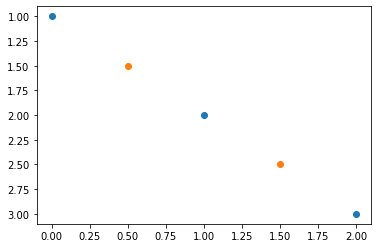

In [15]:
# interp2d([0, 1, 2], [1, 2, 3], [0.5, 1.5], kind='cubic')


from scipy.optimize import curve_fit
x = [0, 1, 2]
y = [1, 2, 3]
plt.gca().invert_yaxis()
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.scatter(x, y)
plt.scatter([0.5, 1.5], p([0.5, 1.5]))

In [16]:
def project_vehicle(x, y, z, ori_x, ori_y, ori_z):
    pos = np.array([x,y,z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector

    new_pos = pos + 4 * ori
    return converter.convert(np.array([new_pos]))

def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit cubic function through points
    z = np.polyfit(points[:, 0], points[:, 1], 2)
    p = np.poly1d(z)

    # Keep interpolating until we have 5 points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points-points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, GAP=5):
    if decode_frame(REF_FRAME)['trafficlights']:
        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(5)])
        return output

    output = []
    for i in range(REF_FRAME, (REF_FRAME + (N_STEP+1+BUFFER*GAP)), GAP):
        if len(output) == N_STEP:
            break

        x, y, z = decode_frame(i)['measurements'][:3]
        image_coords = converter.convert(np.array([[x, y, z]]))
        if len(image_coords) > 0:
            output.append(image_coords[0])

    if len(output) < 2:
        # First try with smaller GAP
        if GAP == 5:
            return get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, GAP=1)

        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(5)])
        return output

    if len(output) >= 2 and len(output) < 5:
        return interpolate_waypoints(np.array(output))

    return np.array(output)

In [17]:
# REF_FRAME = 800
N_STEP = 5
BUFFER = 40

np.set_printoptions(suppress=True)

all_wp = []
N = int((len(out)-1)/ 7)

for frame in tqdm(range(N - (N_STEP * BUFFER) - 1)):
        # Extract world coordinates from dataset
        world_coords = decode_frame(frame)['measurements']
        world_x, world_y, world_z, ori_x, ori_y, ori_z, _, _, _, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch = world_coords[:15]

        sensor_transform = Transform(Location(cam_x, cam_y, cam_z), Rotation(cam_yaw, cam_roll, cam_pitch))
        converter = CoordinateConverter(sensor_transform, fov=120)

        image_coord_wp = get_waypoints(frame, world_x, world_y, world_z, ori_x, ori_y, ori_z)

        all_wp.append(image_coord_wp[:, :2])

100%|██████████| 1990/1990 [00:06<00:00, 315.64it/s]


## Results

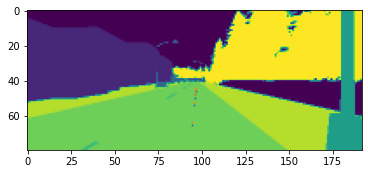

In [67]:
N = 1989
# plot_results(N, i, [all_wp[N]])

plt.imshow(down_scale(decode_frame(N)['segmentation'][:, :, 0]))
temp_wp = all_wp[N].copy()

temp_wp /= 2
# temp_wp[:, 0] /= 2
# temp_wp[:, 1] /= 2


plt.scatter(temp_wp[:, 0], temp_wp[:, 1], s=1)
plt.scatter(temp_wp[:, 0], temp_wp[:, 1]-2, s=1)
plt.show()

## Create video

In [20]:
R = 1


video = cv2.VideoWriter('imgs_noise_test/test_video_noise_2.avi', 0, 10, (192, 80))

for i, wp in tqdm(enumerate(all_wp)):
    img = down_scale(decode_frame(i)['segmentation'][:, :, 0])
    for x, y in wp:
        x = int(x/2)
        y = int(y/2)
        img[y - R: y + R + 1, x - R: x + R + 1] = 12
    
    norm_image = cv2.normalize(img, None, alpha=0, beta=250, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    imgC = cv2.applyColorMap(norm_image, cv2.COLORMAP_JET)
#     plt.imshow(imgC)
#     plt.show()
    video.write(imgC)
#     cv2.imwrite(f'imgs_noise_test/frame_{i}.png',  imgC)
    
video.release()

2329it [00:01, 1358.06it/s]


# Augmentations

In [22]:
def plot_augmentation(original, augmented):
    plt.figure(figsize=(12,6))
    plt.title("Original")
    plt.imshow(original)
    plt.show()

    plt.figure(figsize=(12,6))
    plt.title("Augmented")
    plt.imshow(augmented)
    plt.show()

In [23]:
import imgaug.augmenters as iaa
import imgaug as ia
from imgaug.augmentables import Keypoint, KeypointsOnImage


def affine(image):
    aug = iaa.Affine(translate_px={"x": (-30, 30), "y": (0, -5)}, scale={"x": (1, 1.15), "y": (1, 1.15)}, mode='reflect')


    return aug(images=image)

# def dropout(image):
#     aug = iaa.Dropout(p=(0, 0.1), per_channel=0.5)
#     return aug(images=image)

# def blur(image):
#     aug = iaa.MotionBlur(k=5, angle=[-90, 0, 90])
#     return aug(images=image)


sometimes = lambda aug: iaa.Sometimes(0.33, aug)
seq = iaa.Sequential(
        [
            sometimes(
                iaa.Affine(
                    translate_px={"x": (-15, 15), "y": (0, -5)},
                    scale={"x": (1, 1.15), "y": (1, 1.15)},
                    mode='reflect')
            ),
            sometimes(
                iaa.Dropout(
                    p=(0, 0.1),
                    per_channel=0.5)
            ),
            sometimes(
                iaa.MotionBlur(
                    k=(3,5),
                    angle=[-90, 0, 90])
            )
        ],
    random_order=True)


# seq = iaa.Affine(translate_px={"x": (-15, 15), "y": (0, -5)}, scale={"x": (1, 1.15), "y": (1, 1.15)}, mode='reflect')

759


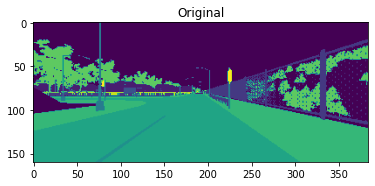

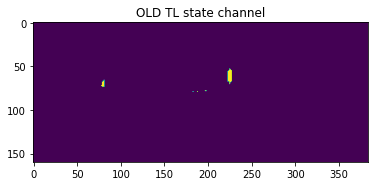

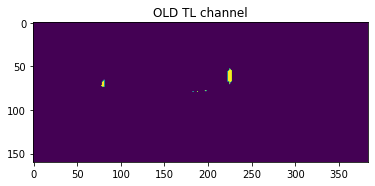

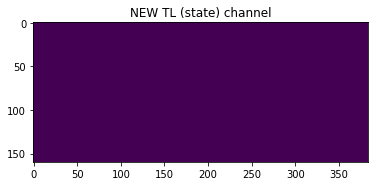

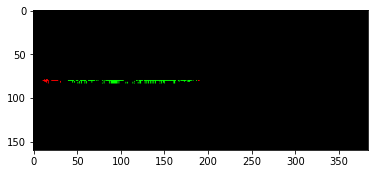

In [65]:
for i in range(1000):
    temp_img = decode_frame(i)['segmentation']
    temp_tl = decode_frame(i)['trafficlights']
    
    if temp_tl:
        print(i)
        break
    

temp_img = decode_frame(759)['segmentation']
temp_tl = decode_frame(759)['trafficlights']

plt.title("Original")
plt.imshow(temp_img[:, :, 0])
plt.show()

plt.title("OLD TL state channel")
plt.imshow(seg2D_to_ND(temp_img, 1)[:, :, 13:14])
plt.show()

plt.title("OLD TL channel")
plt.imshow(seg2D_to_ND(temp_img, 1)[:, :, 12:13])
plt.show()



plt.title("NEW TL (state) channel")
plt.imshow(seg2D_to_ND_new(temp_img, 0)[:, :, 12:13])
plt.show()


plt.imshow(seg2D_to_ND_new(temp_img, 0)[:, :, 10:13])
plt.show()

TypeError: Invalid shape (160, 384, 14) for image data

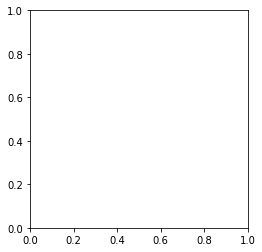

In [27]:
def points_to_keypoints(points, shape):
    kps = KeypointsOnImage([
        Keypoint(x=points[0][0], y=points[0][1]),
        Keypoint(x=points[1][0], y=points[1][1]),
        Keypoint(x=points[2][0], y=points[2][1]),
        Keypoint(x=points[3][0], y=points[3][1]),
        Keypoint(x=points[4][0], y=points[4][1])
        ], shape=shape)

    return kps


def augment_image(image, points, redo=0):
    if redo >= 5:
        print("J")
        return image, points

    image_aug, p_aug = seq(image=down_scale(image), keypoints=points_to_keypoints(points/2, (80, 192)))
    temp = p_aug.to_xy_array()
    if not np.all((temp[:, 0] <= 192) & (temp[:, 1] <= 80)):
        return augment_image(image, points, redo=redo+1)

    return image_aug, temp

for i in range(0, 500, 100):
    temp_img = decode_frame(i)['segmentation']
    temp_img = seg2D_to_ND(temp_img, 0)
    img_aug, points_aug = augment_image(temp_img, all_wp[i])
    plt.scatter(points_aug[:, 0], points_aug[:, 1])
    plt.show()

In [ ]:
def points_to_keypoints(points, shape):
    kps = KeypointsOnImage([
        Keypoint(x=points[0][0], y=points[0][1]),
        Keypoint(x=points[1][0], y=points[1][1]),
        Keypoint(x=points[2][0], y=points[2][1]),
        Keypoint(x=points[3][0], y=points[3][1]),
        Keypoint(x=points[4][0], y=points[4][1])
        ], shape=shape)

    return kps



imgs, new_kps = seq(images=[down_scale(decode_frame(i)['segmentation'][:, :, 0]) for i in range(0, 500, 50)], keypoints=[points_to_keypoints(all_wp[i]/2, (80, 192)) for i in range(0, 500, 50)])
for img, new_kp in zip(imgs, new_kps):
    plt.imshow(img)
    points_temp = new_kp.to_xy_array()
    plt.scatter(points_temp[:, 0], points_temp[:, 1])
    plt.show()

In [19]:
def down_scale(img):
    new_shape = (img.shape[0]//2, img.shape[1]//2)
    img = np.moveaxis(img, 1, 0)
    img = cv2.resize(img.astype(np.float32), new_shape)
    img = np.moveaxis(img, 1, 0)

    return img

b = decode_frame(1)['segmentation']
b = seg2D_to_ND(b, 0)
b = down_scale(b)

plt.imshow(b[:, :, 6:9])
plt.show()


plot_augmentation(b[:, :, 6:9], seq(image=b)[:, : ,6:9])

NameError: name 'seg2D_to_ND' is not defined

In [51]:
def seg2D_to_ND_new(seg, tl_info, combine=False):
    """Converts 2D segmentation image to ND array with N boolean masks.
    Where N corresponds to number of segmentation classes."""
    if combine:
        return seg2D_to_ND_combined(seg, tl_info)

    seg = seg[:, :, 0]  # CARLA stores segmentation values in R channel
    mask = np.zeros((*seg.shape, N_CLASSES))

    # Do not add traffic light state yet
    for i in range(N_CLASSES-1):
        mask[..., i][seg == i] = 1

    # Add traffic light state, 12 is traffic sign class
    mask[..., 12][seg == 12] = tl_info

    return mask

# Playground

In [25]:
N_CLASSES = 13
N_CLASSES_COMBINED = 6
KEEP_CLASSES = {4,6,7,10,12}
N_TRAFFIC_LIGHT_STATES = 1

def seg2D_to_ND_combined(seg, tl_info):
    seg = seg[:, :, 0]  # CARLA stores segmentation values in R channel
    mask = np.zeros((*seg.shape, N_CLASSES_COMBINED + N_TRAFFIC_LIGHT_STATES))

    for i, seg_class in enumerate(KEEP_CLASSES):
        mask[..., i][seg == seg_class] = 1

    TO_COMBINE = set(range(N_CLASSES))-KEEP_CLASSES
    for i in TO_COMBINE:
        mask[..., len(KEEP_CLASSES)] += seg==i

    if tl_info == 0:
        return mask

    # Select channel and set binary mask, 12 is traffic sign class
    mask[..., N_CLASSES_COMBINED][seg == 12] = 1

    return mask

def seg2D_to_ND(seg, tl_info, combine=False):
    """Converts 2D segmentation image to ND array with N boolean masks.
    Where N corresponds to number of segmentation classes."""
    if combine:
        return seg2D_to_ND_combined(seg, tl_info)

    seg = seg[:, :, 0]  # CARLA stores segmentation values in R channel
    mask = np.zeros((*seg.shape, N_CLASSES + N_TRAFFIC_LIGHT_STATES))

    for i in range(N_CLASSES):
        mask[..., i][seg == i] = 1

    if tl_info == 0:
        return mask

    # Select channel and set binary mask, 12 is traffic sign class
    mask[..., N_CLASSES][seg == 12] = 1

    return mask

In [ ]:
t = seg2D_to_ND(decode_frame(N)['segmentation'], decode_frame(N)['trafficlights'], combine=True)
print(t[-2].shape)
plt.imshow(t[..., -2])
plt.show()

In [ ]:
PIXEL_OFFSET = 10

def draw_msra_gaussian(heatmap, center, sigma):
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap


def world_to_pixel(
        x,y,ox,oy,ori_ox, ori_oy,
        pixels_per_meter=5, offset=(-80,160), size=320, angle_jitter=15):
    pixel_dx, pixel_dy = (x-ox)*pixels_per_meter, (y-oy)*pixels_per_meter

    pixel_x = pixel_dx*ori_ox+pixel_dy*ori_oy
    pixel_y = -pixel_dx*ori_oy+pixel_dy*ori_ox

    pixel_x = size-pixel_x

    return np.array([pixel_x, pixel_y]) + offset

def test_get_item(bird_view, segmentation, tl_info, measurement, segs=False):
    crop_x_jitter = 5
    crop_y_jitter = 0
    angle_jitter =  5
    img_size = 320
    crop_size = 192
    crop_size_y = 80
    down_ratio = 4
    gap = 5
    gaussian_radius = 1.0
    n_step = 5
    segmentation = seg2D_to_ND(segmentation, tl_info, combine=False)
    rgb_image = None

    ox, oy, oz, ori_ox, ori_oy, vx, vy, vz, _, _, _, _, _, _, ax, ay, az, cmd, steer, throttle, brake, manual, gear  = measurement
    speed = np.linalg.norm([vx,vy,vz])

    oangle = np.arctan2(ori_oy, ori_ox)
    delta_angle = np.random.randint(-angle_jitter,angle_jitter+1)
    dx = np.random.randint(-crop_x_jitter,crop_x_jitter+1)
    dy = np.random.randint(0,crop_y_jitter+1) - PIXEL_OFFSET

    o_camx = ox + ori_ox*2
    o_camy = oy + ori_oy*2

#     if segs:
    pixel_ox = 192
    pixel_oy = 130

    # RANDOM WARPING
    segmentation = cv2.warpAffine(
            segmentation,
            cv2.getRotationMatrix2D((pixel_ox,pixel_oy), delta_angle, 1.0),
            segmentation.shape[1::-1], flags=cv2.INTER_LINEAR)

    center_x, center_y = pixel_ox, pixel_oy-crop_size_y//2
    segmentation = segmentation[
            dy+center_y-crop_size_y//2:dy+center_y+crop_size_y//2,
            dx+center_x-crop_size//2:dx+center_x+crop_size//2]

    angle = np.arctan2(ori_oy, ori_ox) + np.deg2rad(delta_angle)
    ori_ox, ori_oy = np.cos(angle), np.sin(angle)

    locations = []
    orientations = []

    # LOCATION MODIFICATION
    for dt in range(gap, gap*(n_step+1), gap):
        f_measurement = decode_frame(N+dt)['measurements']
        x, y, z, ori_x, ori_y = f_measurement[:5]
#         x, y, z, ori_x, ori_y, ori_z = f_measurement[:6]
#         rot, loc = rotation(ori_x, ori_y, ori_z), np.array([x, y, z])
#         inv_m = get_inv_matrix(rot, loc)

        pixel_y, pixel_x = world_to_pixel(x,y,ox,oy,ori_ox,ori_oy,size=160, offset=(-80,192))
        pixel_x = pixel_x - (384-crop_size)//2
        pixel_y = crop_size_y - (160-pixel_y)+70

        pixel_x -= dx
        pixel_y -= dy

        angle = np.arctan2(ori_y, ori_x) - np.arctan2(ori_oy, ori_ox)
        ori_dx, ori_dy = np.cos(angle), np.sin(angle)

        locations.append([x, y, z])
        orientations.append([ori_dx, ori_dy])


    # Create mask
    output_size = crop_size // down_ratio
    heatmap_mask = np.zeros((n_step, output_size, output_size), dtype=np.float32)
    regression_offset = np.zeros((n_step,2), np.float32)
    indices = np.zeros((n_step), dtype=np.int64)

    for i, (pixel_x, pixel_y, _) in enumerate(locations):
        center = np.array(
                [pixel_x / down_ratio, pixel_y / down_ratio],
                dtype=np.float32)
        center = np.clip(center, 0, output_size-1)
        center_int = np.rint(center)

        draw_msra_gaussian(heatmap_mask[i], center_int, gaussian_radius)
        regression_offset[i] = center - center_int
        indices[i] = center_int[1] * output_size + center_int[0]
    out = []
    out.append([segmentation, bird_view, np.array(locations), cmd, speed])
#     else:
    pixel_ox = 160
    pixel_oy = 260


    # RANDOM WARPING
    bird_view = cv2.warpAffine(
            bird_view,
            cv2.getRotationMatrix2D((pixel_ox,pixel_oy), delta_angle, 1.0),
            bird_view.shape[1::-1], flags=cv2.INTER_LINEAR)


    # RANDOM CROPPING
    center_x, center_y = 160, 260-crop_size//2
    bird_view = bird_view[
            dy+center_y-crop_size//2:dy+center_y+crop_size//2,
            dx+center_x-crop_size//2:dx+center_x+crop_size//2]

    angle = np.arctan2(ori_oy, ori_ox) + np.deg2rad(delta_angle)
    ori_ox, ori_oy = np.cos(angle), np.sin(angle)

    locations = []
    orientations = []

    # LOCATION MODIFICATION
    for dt in range(gap, gap*(n_step+1), gap):
        f_measurement = decode_frame(N+dt)['measurements']
        x, y, z, ori_x, ori_y = f_measurement[:5]

#         x, y, z, ori_x, ori_y, ori_z = f_measurement[:6]
#         rot, loc = rotation(ori_x, ori_y, ori_z), np.array([x, y, z])
#         inv_m = get_inv_matrix(rot, loc)

        pixel_y, pixel_x = world_to_pixel(x,y,ox,oy,ori_ox,ori_oy,size=img_size)
        pixel_x = pixel_x - (img_size-crop_size)//2
        pixel_y = crop_size - (img_size-pixel_y)+70

        pixel_x -= dx
        pixel_y -= dy

        angle = np.arctan2(ori_y, ori_x) - np.arctan2(ori_oy, ori_ox)
        ori_dx, ori_dy = np.cos(angle), np.sin(angle)

        locations.append([x, y, z])
        orientations.append([ori_dx, ori_dy])


    # Create mask
    output_size = crop_size // down_ratio
    heatmap_mask = np.zeros((n_step, output_size, output_size), dtype=np.float32)
    regression_offset = np.zeros((n_step,2), np.float32)
    indices = np.zeros((n_step), dtype=np.int64)

    for i, (pixel_x, pixel_y, _) in enumerate(locations):
        center = np.array(
                [pixel_x / down_ratio, pixel_y / down_ratio],
                dtype=np.float32)
        center = np.clip(center, 0, output_size-1)
        center_int = np.rint(center)

        draw_msra_gaussian(heatmap_mask[i], center_int, gaussian_radius)
        regression_offset[i] = center - center_int
        indices[i] = center_int[1] * output_size + center_int[0]

    out.append([segmentation, bird_view, np.array(locations), cmd, speed])
    return np.array(out)

In [ ]:
N_FIG = 6
out_temp = []
for i in range(N_FIG):
    N = i + 10
    temp = test_get_item(decode_frame(N)['birdview'], decode_frame(N)['segmentation'], decode_frame(N)['trafficlights'], decode_frame(N)['measurements'])
    out_temp.append(temp)

out_temp = np.array(out_temp)

In [ ]:
REF_FRAME = 0
NEXT_FRAME = 2

In [ ]:
# Extract world coordinates from dataset
world_coords = decode_frame(REF_FRAME)['measurements']
world_x, world_y, world_z, _, _, _, _, _, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch = world_coords[:14]

print("CURRENT LOCATION:", world_x, world_y, world_z)
# Get sensor transform
sensor_transform = Transform(Location(cam_x, cam_y, cam_z), Rotation(cam_yaw, cam_roll, cam_pitch))

In [ ]:
plt.figure(figsize=(12,60))

for i in range(N_FIG):
    # NEW SEG
    plt.subplot(N_FIG, 2, (i*2)+1)
    plt.imshow(out_temp[i][0][0][..., 6:9])
    plt.scatter(out_temp[i][0][2][:,0], out_temp[i][0][2][:,1])

    # OLD BIRDVIEW
    plt.subplot(N_FIG, 2, (i*2)+2)
    plt.imshow(out_temp[i][1][1][:, :, :3])
    plt.scatter(out_temp[i][1][2][:,0], out_temp[i][1][2][:,1])

plt.show()

In [ ]:
plt.figure(figsize=(12,20))

for i in range(N_FIG):
    # NEW SEG
    plt.subplot(N_FIG, 2, (i*2)+1)
    plt.imshow(out_temp[i][0][0][..., 6:9])
    plt.scatter(out_temp[i][0][2][:,0], out_temp[i][0][2][:,1])

    # OLD BIRDVIEW
    plt.subplot(N_FIG, 2, (i*2)+2)
    plt.imshow(out_temp[i][1][1][:, :, :3])
    plt.scatter(out_temp[i][1][2][:,0], out_temp[i][1][2][:,1])

plt.show()